# Training Surrogates

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OJWatson/emidm/blob/main/examples/surrogate_notebook.ipynb)

This notebook demonstrates how to generate data using a Susceptible-Infected-Recovered (SIR) model with the `emidm` package. The generated data can be used to train deep learning surrogates for infectious disease modeling.

The first two sections (`Generate Simulation Data` and `Prepare Training Dataset`) make use of `emidm` to generate our training data and are provided in brief to show what data is being generated and to ease into the notebook. The next three sections introduce how to train your surrogate model, validate this and explore ways of using this. 

The last section are possible extensions for those who finish early, which ask you to think about tweaking the code used to test your understanding about how surrogates are trained, or to explore how to use them further analysis.

## Objectives

- Simulate SIR model dynamics using the `emidm` package.
- Generate multiple realizations of the model with varying parameters.
- Prepare the simulated data for training deep learning surrogates.
- Train different surrogate models and compare these
- Visualise performance of surrogates

## Prerequisites

We will be using the helper functions in the `emidm` package, which will be installed and all relevant modules from this as well as other required packages loaded below in two steps. 

First we will install `emidm` from Github:

In [1]:
%pip install git+https://github.com/OJWatson/emidm.git

155.41s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Cloning https://github.com/OJWatson/emidm.git to /tmp/pip-req-build-b2stl05s
  Running command git clone --filter=blob:none --quiet https://github.com/OJWatson/emidm.git /tmp/pip-req-build-b2stl05s
  Resolved https://github.com/OJWatson/emidm.git to commit ce6af259f02b5dd99c4468ca5a92458f8a390be0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


Next we will import any required modules once here. If this works then the rest of the notebook should work 🤞:

In [18]:
# Imports from the emidm package that we have just installed
from emidm.sir import run_sir, run_model_with_replicates, plot_model_outputs
from emidm.sampler import generate_lhs_samples

# imports from other packages
import pandas as pd
import numpy as np

# for those who like me prescrbe to Hadley Wickham's one truth of a grammar of graphics
from plotnine import ggplot, aes, geom_line, facet_wrap

# progress on loops in notebooks
from tqdm.notebook import tqdm

## 1. Generate Simulation Data

### Running a Single SIR Model Simulation

We can use `emidm` to ssimulate the SIR model dynamics using default parameters:

In [3]:
# Demonstrate running one model
single = run_sir()

# Show the output
single

,t,N,S,I,R
0,0,1000,990,10,0
1,1,1000,987,10,3
2,2,1000,987,9,4
3,3,1000,985,10,5
4,4,1000,979,16,5
...,...,...,...,...,...
96,96,1000,168,14,818
97,97,1000,168,12,820
98,98,1000,166,11,823
99,99,1000,166,11,823


The output is a `pandas DataFrame` containing the number of susceptible (S), infected (I), and recovered (R) individuals over time.

To visualize the results:

<Axes: xlabel='t'>

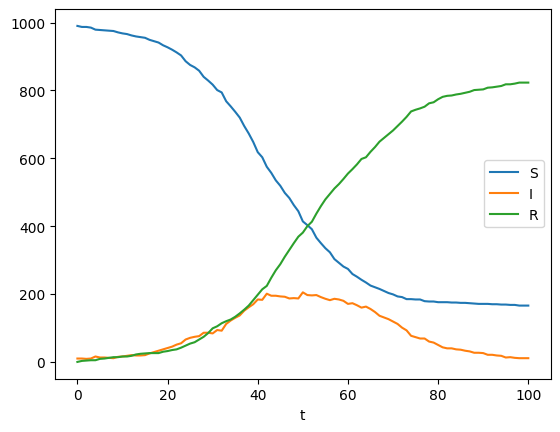

In [4]:
# Show a single plot line
single.plot("t", ["S", "I", "R"])

We can adjust parameters such as the transmission rate (`beta`) to observe different dynamics:

<Axes: xlabel='t'>

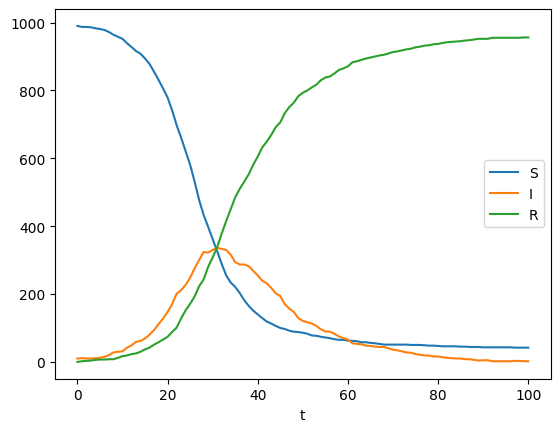

In [5]:
# We can also vary the parameters and plot these outputs
alt = run_sir(beta = 0.3)
alt.plot("t", ["S", "I", "R"])

### Running Multiple Stochastic Realisations

To account for stochasticity, we can run multiple realizations of the model:

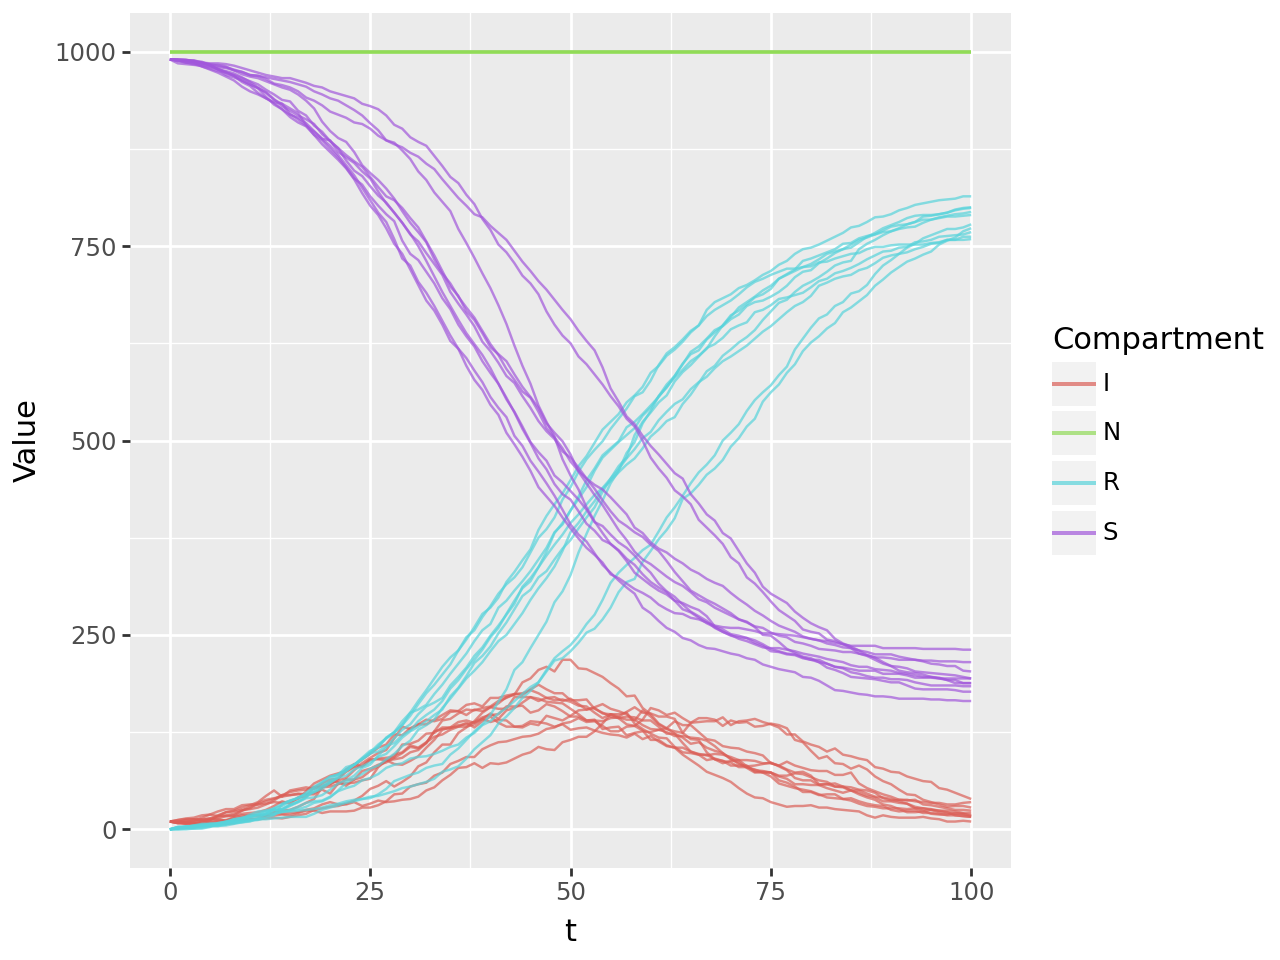

In [6]:
# we can run multiple realisations
reps = run_model_with_replicates(model = run_sir, reps = 10)

# and plot these - ahhh a ggplot my friend
p = plot_model_outputs(reps)

And we can also pass through any of the arguments to `run_sir` to our `run_model_with_replicates` function.

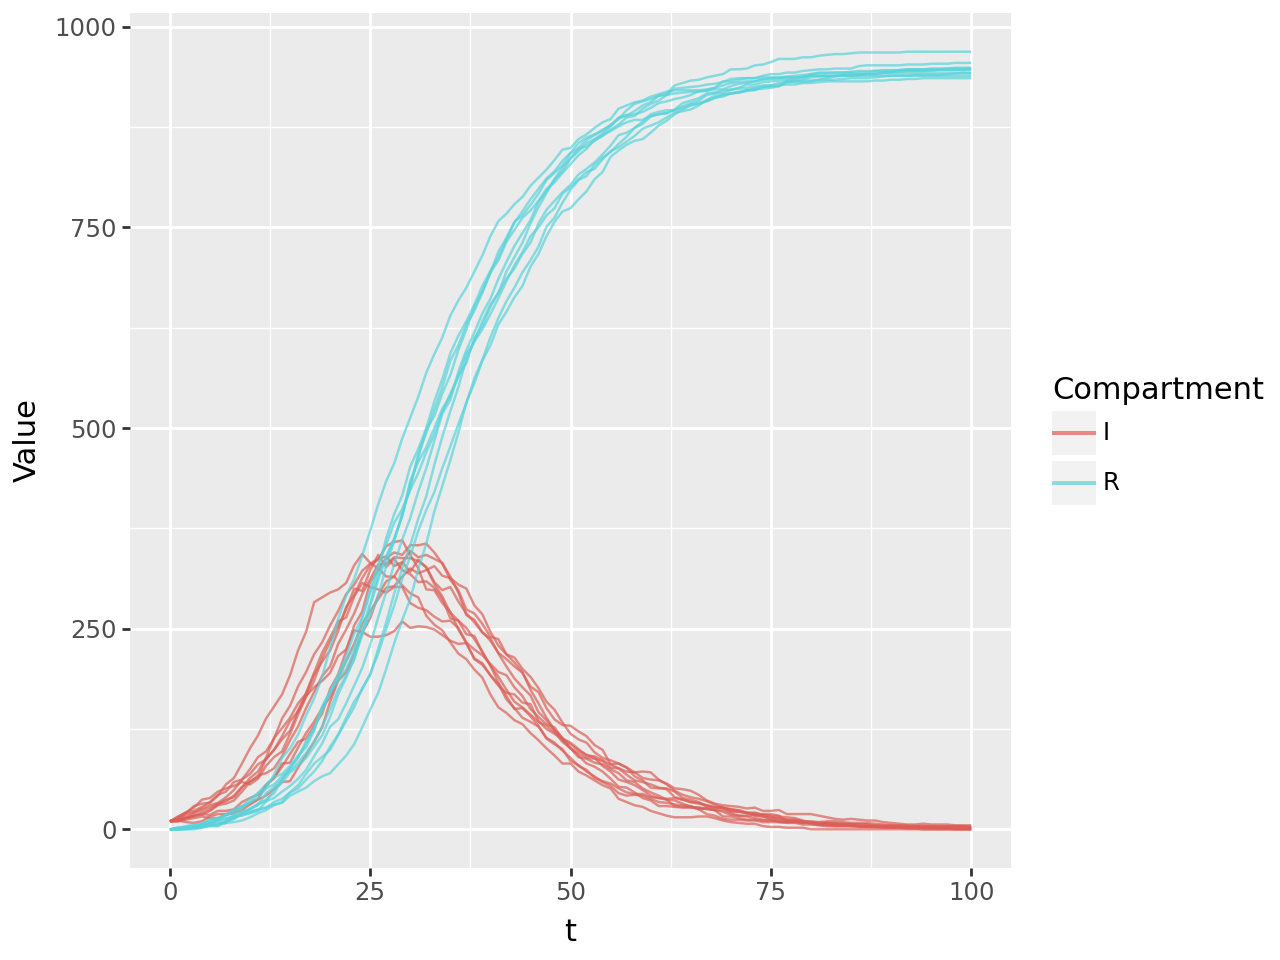

In [7]:
# we can also by args to run_sir through kwargs
reps = run_model_with_replicates(model=run_sir, reps=10, beta = 0.3)

# and plot these
p = plot_model_outputs(reps, columns = ["I", "R"])

## 2. Prepare Training Dataset

### Sampling Parameter Space with Latin Hypercube Sampling

To systematically explore the parameter space, we use Latin Hypercube Sampling (LHS), which we have again provided helper functions from `emidm` for you to use.


In [8]:
# Start by providing a dictionary of the ranges for each parameter to be sampled
param_ranges = {"beta": [0.1, 0.5], "gamma": [0.05, 0.5]}

# Generate Latin Hypercube Samples
df_samples = generate_lhs_samples(param_ranges, n_samples=9, seed=42)
df_samples

,beta,gamma
0,0.376713,0.228056
1,0.150729,0.165132
2,0.229148,0.351219
3,0.421727,0.310697
4,0.272084,0.127481
5,0.350187,0.253662
6,0.471384,0.458862
7,0.302515,0.088638
8,0.119796,0.446809


This generates a set of parameter combinations, which we can then pass to our `run_model_with_replicates` function. We have just used 9 samples here initially just to show you the outputs and understand it. Later we will generate more samples to build a robust training dataset.

In [9]:
# Run the model for each row of samples:
results = [
    run_model_with_replicates(**row.to_dict(), reps=10).assign(**row.to_dict())
    for _, row in df_samples.iterrows()
]

# Combine results into one DataFrame:
df_all_results = pd.concat(results, axis=0)

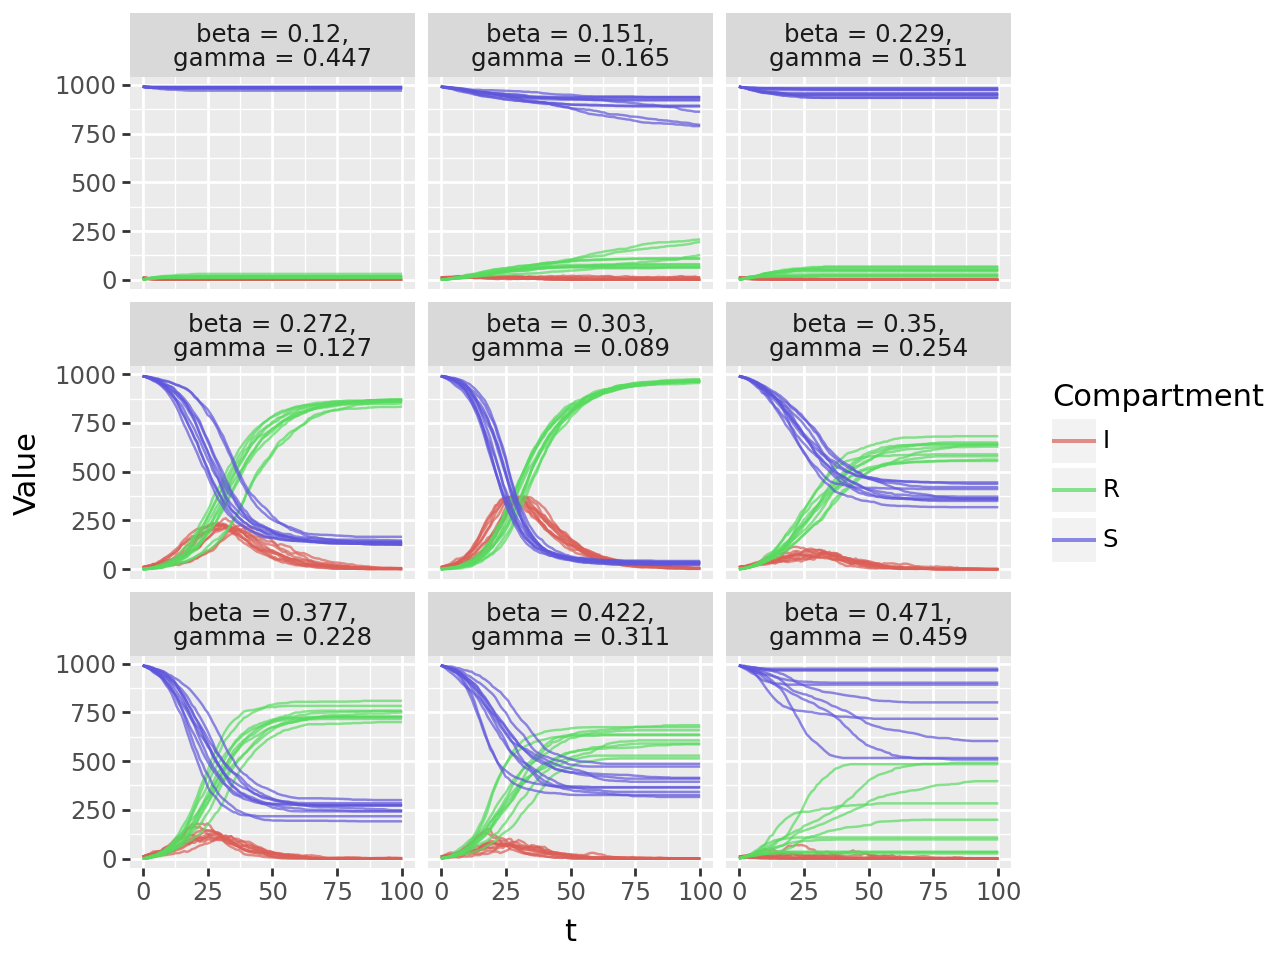

In [10]:
# Reshape dataframe into tidy long-format
df_long = df_all_results.melt(
    id_vars=["t", "replicate", "gamma", "beta"],
    value_vars=["S", "I", "R"],
    var_name="Compartment",
    value_name="Value",
)

# Add unique identifier for group plotting
df_long = df_long.assign(
    uid=df_long["Compartment"]
    + df_long["replicate"].astype(str)
)

# Add facet identifier for group plotting
df_long = df_long.assign(
    facet="beta = "
    + df_long["beta"].round(3).astype(str)
    + ",\n"
    + "gamma = "
    + df_long["gamma"].round(3).astype(str)
)

# Plot: color by compartment, lines grouped by replicate
p = (
    ggplot(
        df_long,
        aes(x="t", y="Value", group="uid", color="Compartment"),
    )
    + geom_line(alpha=0.7)
    + facet_wrap("facet")
)

# Explicitly plot
ggplot.show(p)

### Generating Training and Test Data

Now that we have seen how LHS is being used to sample different $\beta$ and $\gamma$ parameters and to generate simulations, we will now generate training and test data in much the same way:   

In [16]:
n_train_samples = 1000
n_test_samples = 100

# generate train samples and data
train_samples = generate_lhs_samples(param_ranges, n_samples=n_train_samples, seed=42)
train_data = [
    run_model_with_replicates(**row.to_dict(), reps=5).assign(**row.to_dict())
    for _, row in tqdm(train_samples.iterrows(), total=len(train_samples))
]

# generate test samples
test_samples = generate_lhs_samples(param_ranges, n_samples=n_test_samples, seed=42)
test_data = [
    run_model_with_replicates(**row.to_dict(), reps=5).assign(**row.to_dict())
    for _, row in tqdm(test_samples.iterrows(), total = len(test_samples))
]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

## 3. Train a neural network

### Creating Dataset Class and Dataloader

While we have generated our training and test data, we need to prepare it into a PyTorch dataset and dataloader. The dataloader is a way of iterating through our data in batches, which is useful for training deep learning models. Batches are used to train the model in mini-batches, which is more efficient than training on the entire dataset at once. It also has the advantage of allowing us to use GPU acceleration if available. 

We have not created this dataset class yet in `emidm`, so that we can show you how it works, so we will do that next. We will also use this an opportunity to learn a bit more about PyTorch and also how (more often) Python leverages classes. 

First, let's remind ourselves what our data looks like

In [24]:
test_data.__class__

### Dataset and Scaling

We first construct a custom PyTorch dataset that formats are simulation runs into input-output pairs. For each simulation run produces an input sequence `X` of shape `(T, 1+2)`:

- The **first column** is a normalized time feature (values between 0 and 1).
- The **remaining columns** are the simulation parameters ($\beta$, $\gamma$) repeated over all time steps. 

The target `Y` is the time series of total incidence (per day). Both inputs and targets are scaled using `StandardScaler`.

We first construct a custom PyTorch dataset that for each simulation run produces an input sequence X of shape (T, 1+9):

The first column is a normalized time feature (values between 0 and 1).
The remaining columns are the simulation parameters (latent period, infectious period, immunity period, Rt values, and switching times) repeated over all time steps.
The target Y is the time series of total incidence (per day). Both inputs and targets are scaled using StandardScaler